## Experiment 1-  Feature Space Visualisation
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the feature vectors in the feature space by visualising them using PCA

In [1]:
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.color import grey2rgb,rgb2grey
from skimage.feature import hog
from skimage import io

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112
cluster_length=16
feature_size=8192 #4096 #16384
baseline_feature_size=4608
baseline2_feature_size=2


nb_activities=4
nb_videos=5
nb_pixels_per_cell=(8,8)
nb_cells_per_block=(1,1)
nb_orientations=16
saved_path='/nobackup/leopauly/logdirk80_1_rand_frames'
dataset_dir='/nobackup/leopauly/leeds_reordered/'

### Acitivity net

#### Defining model

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, 16,height,width,channel],name='x') 

model_keras = md.C3D_ucf101_training_model_tf(summary=False)
out=model_keras(x_image)

/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_ECCV/modelling.py:281: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_ECCV/modelling.py:283: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_ECCV/modelling.py:286: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/ufaserv1_f/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_ECCV/modelling.py:288: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxP

#### Starting a session - Activity Net

In [4]:
#### Start the session with logging placement.
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))

### Restore model weights from previously saved model
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-104'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/logdirk80_1_rand_frames/activity_model.ckpt-104
Model restored from file: /nobackup/leopauly/logdirk80_1_rand_frames


#### Feature extraction 

In [5]:
## Extraction of features - baseline
def extract_activitynet_video_features(vid):
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0')
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [6]:
def get_compress_frames_data(filename, num_frames_per_clip=cluster_length):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):

    filenames = sorted(filenames)
    #print(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [7]:
activity_folders=sorted(os.listdir(dataset_dir))
activity_subfolders= [['foo' for i in range(nb_videos)] for j in range(nb_activities)]
k=np.array(activity_subfolders)
print(k.shape)
print('activity_folders:',activity_folders)
for i,folder in enumerate(activity_folders):
    activity_subfolders[i]=sorted(os.listdir('/nobackup/leopauly/leeds_reordered'+'/'+folder))
    print(sorted(os.listdir('/nobackup/leopauly/leeds_reordered'+'/'+folder)))
    print('activity subfolders in',folder,'folder :', activity_subfolders[i])

(4, 5)
activity_folders: ['hit', 'pour', 'push', 'reach']
['0', '1', '2', '3', '4']
activity subfolders in hit folder : ['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']
activity subfolders in pour folder : ['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']
activity subfolders in push folder : ['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']
activity subfolders in reach folder : ['0', '1', '2', '3', '4']


In [8]:
## Extracting activity features from each class videos
activitynet_features=[[[0 for x in range(feature_size)] for y in range(nb_videos)] for z in range(nb_activities)]
labels=np.zeros([nb_activities*nb_videos])

ptr=0
for nb_act in range(nb_activities):
    for nb_vid in range(nb_videos):
        temp=0
        temp=get_compress_frames_data(dataset_dir+str(activity_folders[nb_act])+'/'+str(activity_subfolders[nb_act][nb_vid]))
        print(dataset_dir+str(activity_folders[nb_act])+'/'+str(activity_subfolders[nb_act][nb_vid]))
        activitynet_features[nb_act][nb_vid]=extract_activitynet_video_features(temp)
        labels[ptr]=nb_act
        ptr=ptr+1
activitynet_features=np.array(activitynet_features)
ptr=0

/nobackup/leopauly/leeds_reordered/hit/0
/nobackup/leopauly/leeds_reordered/hit/1
/nobackup/leopauly/leeds_reordered/hit/2
/nobackup/leopauly/leeds_reordered/hit/3
/nobackup/leopauly/leeds_reordered/hit/4
/nobackup/leopauly/leeds_reordered/pour/0
/nobackup/leopauly/leeds_reordered/pour/1
/nobackup/leopauly/leeds_reordered/pour/2
/nobackup/leopauly/leeds_reordered/pour/3
/nobackup/leopauly/leeds_reordered/pour/4
/nobackup/leopauly/leeds_reordered/push/0
/nobackup/leopauly/leeds_reordered/push/1
/nobackup/leopauly/leeds_reordered/push/2
/nobackup/leopauly/leeds_reordered/push/3
/nobackup/leopauly/leeds_reordered/push/4
/nobackup/leopauly/leeds_reordered/reach/0
/nobackup/leopauly/leeds_reordered/reach/1
/nobackup/leopauly/leeds_reordered/reach/2
/nobackup/leopauly/leeds_reordered/reach/3
/nobackup/leopauly/leeds_reordered/reach/4


In [9]:
pca_obj = PCA(n_components=2, random_state=0)
vis_activitynet=[pca_obj.fit_transform(activitynet_features[i]) for i  in range(nb_activities)]
vis_activitynet=np.array(vis_activitynet)

In [10]:
tsne_obj = TSNE(n_components=2, verbose=1)
vis_activitynet_tsne=[tsne_obj.fit_transform(activitynet_features[i]) for i  in range(nb_activities)]
vis_activitynet_tsne=np.array(vis_activitynet_tsne)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: -0.000000
[t-SNE] Error after 75 iterations: -0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t

In [11]:
sess.close() 
tf.reset_default_graph()

### Baseline

In [12]:
base_model=md.get_vgg16_imagenet(summary=True,include_fc=False)
#print([n.name for n in tf.get_default_graph().as_graph_def().node])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [13]:
## Extraction of features - baseline
def extract_baseline_video_features(vid):
    
    sum_val=0
    for i in range(cluster_length):
        frame_=vid[i]
        
        #frame_=frame_.reshape(-1,height,width,channel)
        #frame= preprocess_input(frame_) # prepare the image for the VGG model
        
        frame=preprocess(frame_)
        frame=frame.reshape(-1,height,width,channel)
        
        temp_val=base_model.predict(frame)
        temp_val=temp_val.reshape(baseline_feature_size)
        #print('temp_val',temp_val.shape)
        sum_val=sum_val+temp_val
        #print('sum_val',sum_val.shape)
    features=sum_val/cluster_length
    #print('feature from one video.shape',features.shape)
    return features

In [14]:
def preprocess(im):
        im = np.float32(im)
        im[:,:,2] -= 103.939
        im[:,:,1] -= 116.779
        im[:,:,0] -= 123.68
        im = im[:, :, ::-1]  # change to BGR
        return im

In [15]:
## Extracting baseline features from each class videos
baseline_features=[[[0 for x in range(baseline_feature_size)] for y in range(nb_videos)] for z in range(nb_activities)]
#labels=np.zeros([nb_activities*nb_videos])

#ptr=0
for nb_act in range(nb_activities):
    for nb_vid in range(nb_videos):
        temp=0
        temp=get_compress_frames_data(dataset_dir+str(activity_folders[nb_act])+'/'+str(activity_subfolders[nb_act][nb_vid]))
        print(dataset_dir+str(activity_folders[nb_act])+'/'+str(activity_subfolders[nb_act][nb_vid]))
        baseline_features[nb_act][nb_vid]=extract_baseline_video_features(temp)
        #labels[ptr]=nb_act
        #ptr=ptr+1
baseline_features=np.array(baseline_features)
#ptr=0

/nobackup/leopauly/leeds_reordered/hit/0
/nobackup/leopauly/leeds_reordered/hit/1
/nobackup/leopauly/leeds_reordered/hit/2
/nobackup/leopauly/leeds_reordered/hit/3
/nobackup/leopauly/leeds_reordered/hit/4
/nobackup/leopauly/leeds_reordered/pour/0
/nobackup/leopauly/leeds_reordered/pour/1
/nobackup/leopauly/leeds_reordered/pour/2
/nobackup/leopauly/leeds_reordered/pour/3
/nobackup/leopauly/leeds_reordered/pour/4
/nobackup/leopauly/leeds_reordered/push/0
/nobackup/leopauly/leeds_reordered/push/1
/nobackup/leopauly/leeds_reordered/push/2
/nobackup/leopauly/leeds_reordered/push/3
/nobackup/leopauly/leeds_reordered/push/4
/nobackup/leopauly/leeds_reordered/reach/0
/nobackup/leopauly/leeds_reordered/reach/1
/nobackup/leopauly/leeds_reordered/reach/2
/nobackup/leopauly/leeds_reordered/reach/3
/nobackup/leopauly/leeds_reordered/reach/4


In [16]:
pca_obj = PCA(n_components=2, random_state=0)
vis_baseline=[pca_obj.fit_transform(baseline_features[i]) for i  in range(nb_activities)]
vis_baseline=np.array(vis_baseline)

In [17]:
tsne_obj = TSNE(n_components=2, verbose=1)
vis_baseline_tsne=[tsne_obj.fit_transform(baseline_features[i]) for i  in range(nb_activities)]
vis_baseline_tsne=np.array(vis_baseline_tsne)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-S

### Baseline 2

#### Hog feature demo

['00rgb.png', '01rgb.png', '02rgb.png', '03rgb.png', '04rgb.png', '05rgb.png', '06rgb.png', '07rgb.png', '08rgb.png', '09rgb.png', '10rgb.png', '11rgb.png', '12rgb.png', '13rgb.png', '14rgb.png', '15rgb.png', '16rgb.png', '17rgb.png', '18rgb.png', '19rgb.png', '20rgb.png', '21rgb.png', '22rgb.png', '23rgb.png', '24rgb.png', '25rgb.png', '26rgb.png', '27rgb.png', '28rgb.png', '29rgb.png', '30rgb.png', '31rgb.png', '32rgb.png', '33rgb.png', '34rgb.png', '35rgb.png', '36rgb.png', '37rgb.png', '38rgb.png', '39rgb.png']


/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


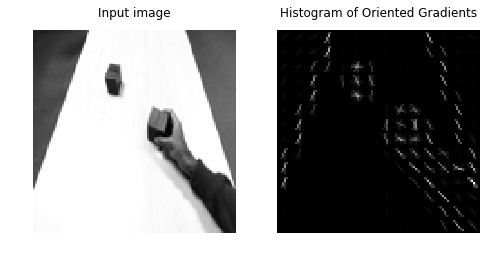

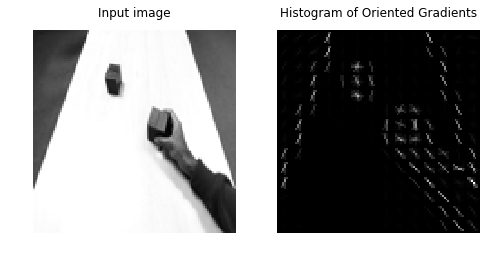

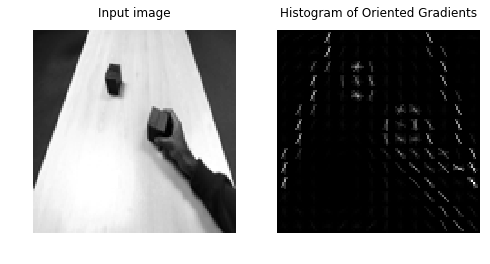

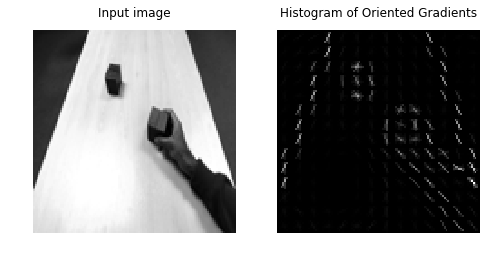

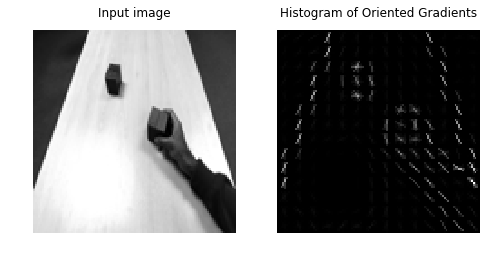

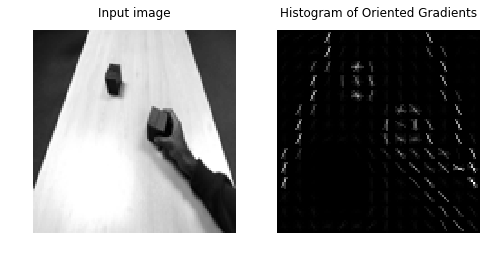

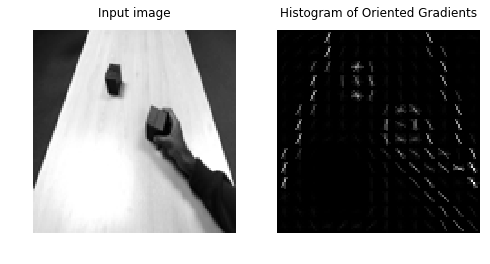

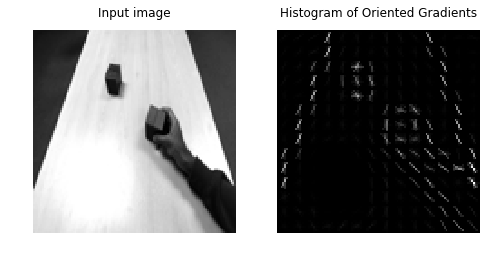

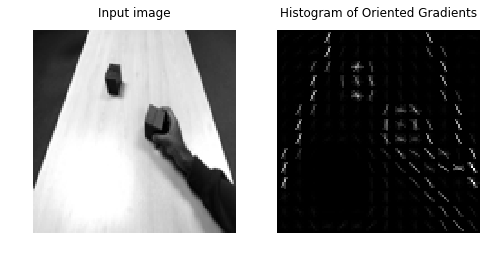

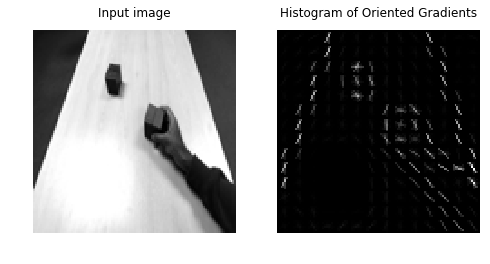

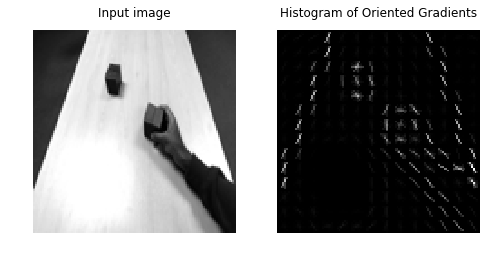

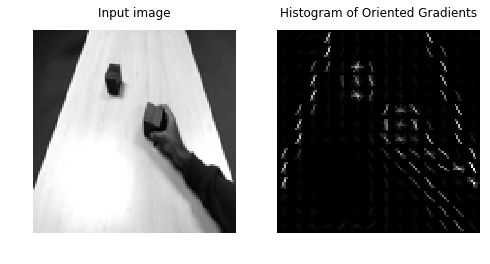

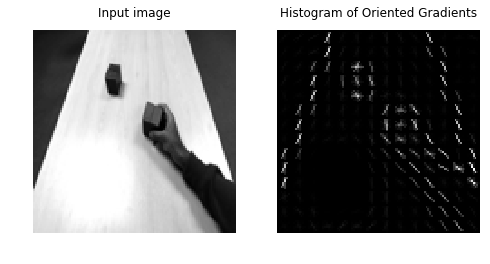

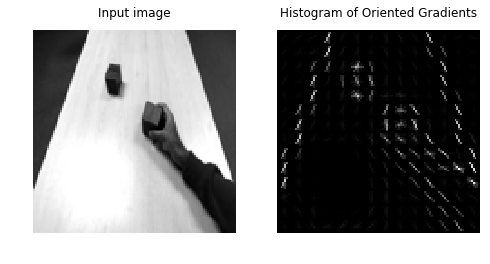

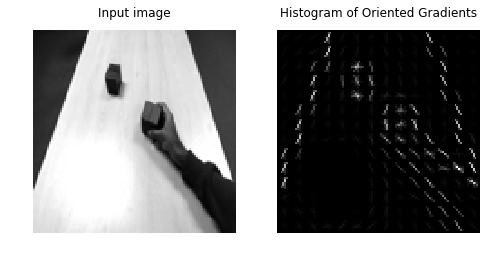

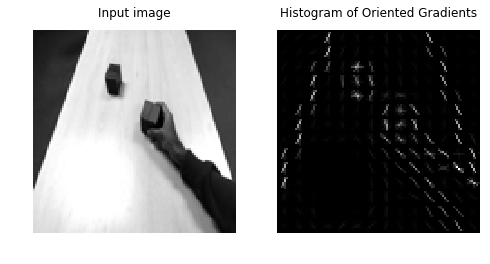

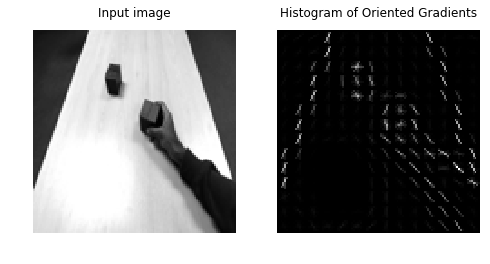

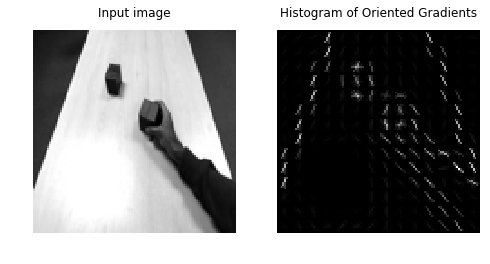

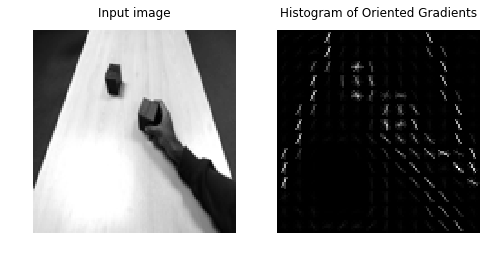

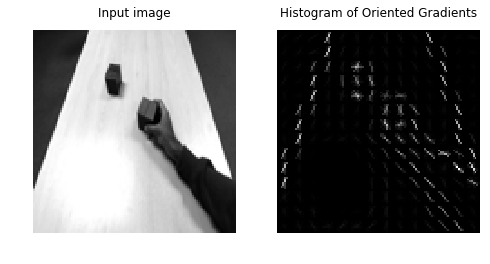

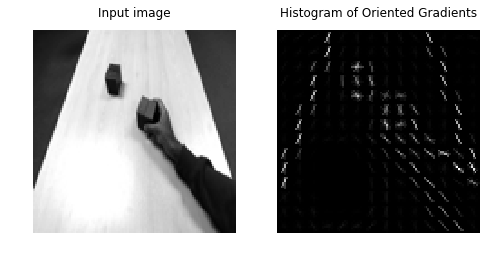

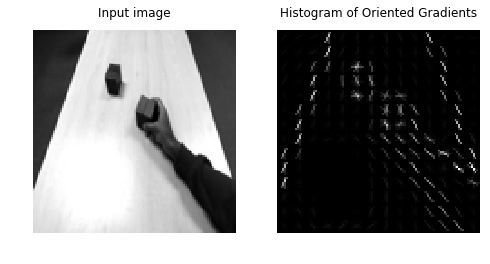

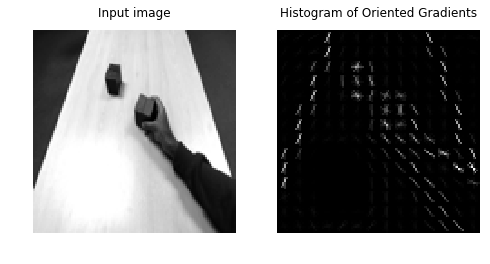

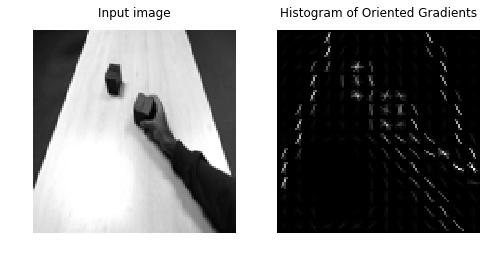

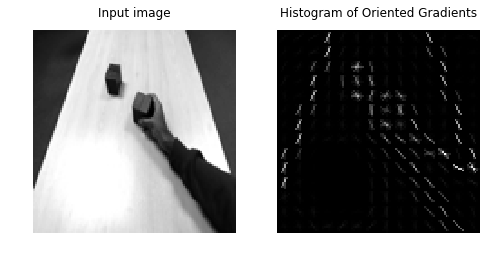

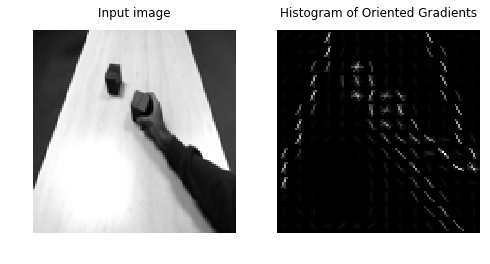

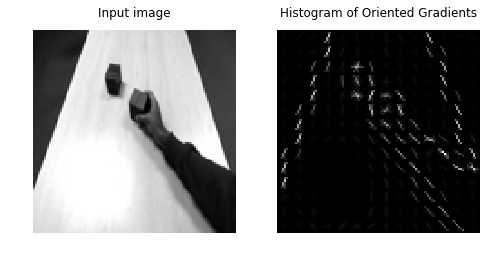

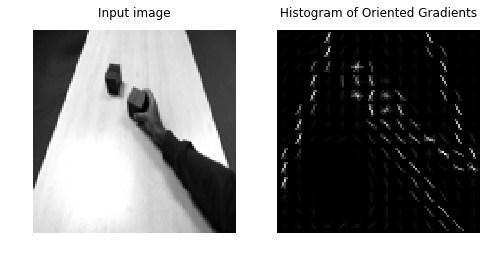

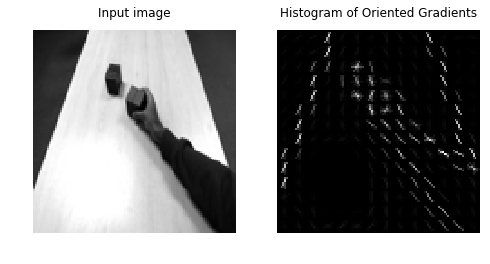

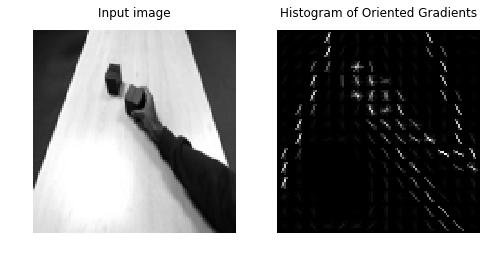

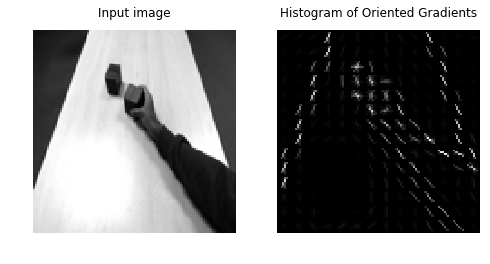

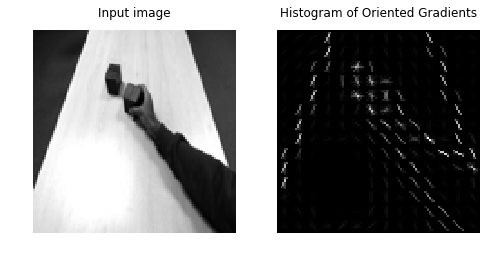

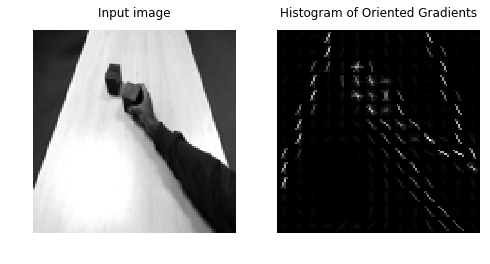

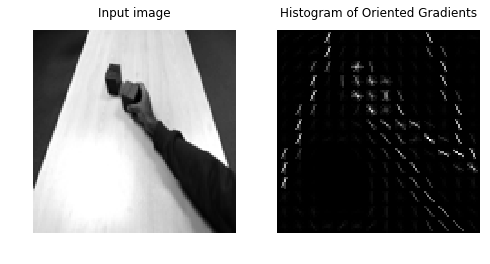

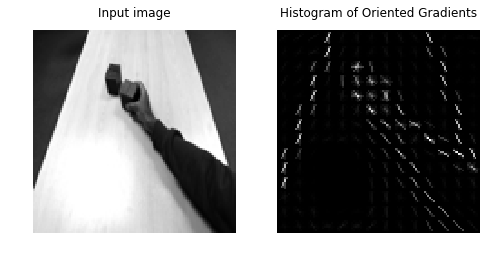

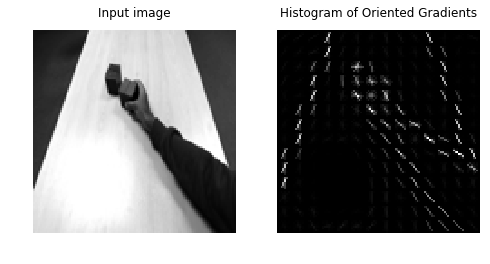

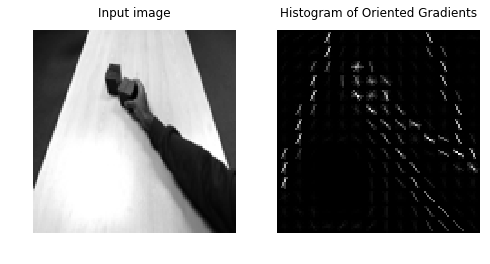

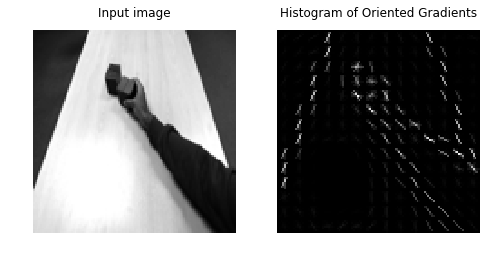

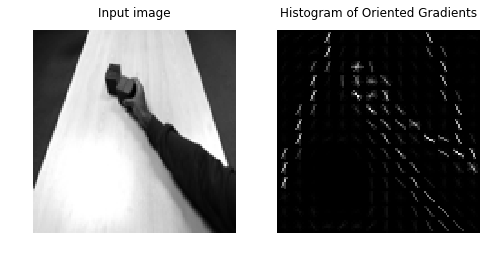

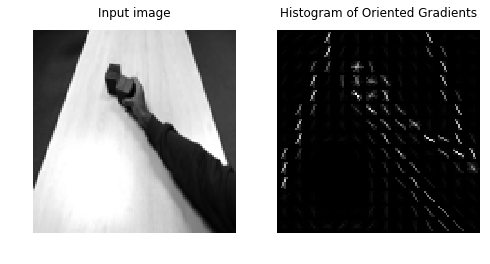

(3136,)


In [26]:
from skimage import data, exposure

hog_dataset='/nobackup/leopauly/leeds_reordered/reach/0/'
filenames= sorted(os.listdir(hog_dataset))
print(filenames)
    
for file in filenames:
        
        image = io.imread(hog_dataset+file,-1)
        fd, hog_image = hog(image, orientations=nb_orientations, pixels_per_cell=nb_pixels_per_cell,cells_per_block=nb_cells_per_block, visualise=True)
        

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(image, cmap=plt.cm.gray)
        ax1.set_title('Input image')

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')

        plt.show()
    
print(fd.shape)

In [19]:
## Extraction of features - baseline2
def extract_baseline2_video_features(vid):

    sum_val=0
    for i in range(cluster_length):
        
        frame_=vid[i]
        frame=rgb2grey(frame_)
        temp_val,_= hog(frame, orientations=nb_orientations, pixels_per_cell=nb_pixels_per_cell,cells_per_block=nb_cells_per_block, visualise=True) #hog.extract(frame)
        temp_val=temp_val.reshape(-1) #print('temp_val',temp_val.shape)
        sum_val=sum_val+temp_val  #print('sum_val',sum_val.shape)
        
    features=sum_val/cluster_length  #print('feature from one video.shape',features.shape)
    return features

In [20]:
## Extracting baseline features from each class videos
baseline2_features=[[[0 for x in range(baseline2_feature_size)] for y in range(nb_videos)] for z in range(nb_activities)]

for nb_act in range(nb_activities):
    for nb_vid in range(nb_videos):
        temp=0
        temp=get_compress_frames_data(dataset_dir+str(activity_folders[nb_act])+'/'+str(activity_subfolders[nb_act][nb_vid]))
        print(dataset_dir+str(activity_folders[nb_act])+'/'+str(activity_subfolders[nb_act][nb_vid]))
        baseline2_features[nb_act][nb_vid]=extract_baseline2_video_features(temp)

baseline2_features=np.array(baseline2_features)

/nobackup/leopauly/leeds_reordered/hit/0
[[[[ 33  38  46]
   [ 29  34  43]
   [ 28  33  41]
   ..., 
   [ 70  77  83]
   [ 70  76  82]
   [ 69  74  82]]

  [[ 32  39  46]
   [ 29  35  42]
   [ 29  33  41]
   ..., 
   [ 73  79  86]
   [ 74  80  86]
   [ 72  78  84]]

  [[ 31  38  45]
   [ 30  35  42]
   [ 32  35  42]
   ..., 
   [ 75  82  88]
   [ 75  81  88]
   [ 73  80  86]]

  ..., 
  [[250 253 229]
   [250 253 232]
   [251 254 234]
   ..., 
   [132  19   6]
   [123  15   4]
   [113  11   1]]

  [[249 253 227]
   [250 253 231]
   [250 253 232]
   ..., 
   [132  20   7]
   [127  18   6]
   [116  12   3]]

  [[248 252 224]
   [251 254 229]
   [249 253 228]
   ..., 
   [124  16   4]
   [130  19   5]
   [124  16   4]]]


 [[[ 19  22  27]
   [ 17  20  25]
   [ 15  18  23]
   ..., 
   [ 45  47  50]
   [ 45  47  50]
   [ 44  47  50]]

  [[ 18  22  27]
   [ 17  20  24]
   [ 16  19  23]
   ..., 
   [ 47  49  52]
   [ 47  49  52]
   [ 45  48  51]]

  [[ 18  21  25]
   [ 17  20  24]
   [ 17  20

/opt/conda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


/nobackup/leopauly/leeds_reordered/hit/1
[[[[ 33  38  45]
   [ 31  33  42]
   [ 30  31  40]
   ..., 
   [ 72  77  84]
   [ 70  75  82]
   [ 71  76  81]]

  [[ 33  38  45]
   [ 31  35  42]
   [ 31  33  40]
   ..., 
   [ 73  79  85]
   [ 74  79  85]
   [ 72  78  83]]

  [[ 33  38  45]
   [ 32  35  41]
   [ 33  36  40]
   ..., 
   [ 76  81  88]
   [ 75  80  87]
   [ 74  80  84]]

  ..., 
  [[250 253 229]
   [250 253 231]
   [251 254 233]
   ..., 
   [252 252 169]
   [253 246 150]
   [252 223 129]]

  [[249 253 226]
   [250 253 229]
   [250 253 230]
   ..., 
   [250 252 171]
   [252 249 155]
   [252 232 135]]

  [[248 252 224]
   [251 255 228]
   [250 254 228]
   ..., 
   [251 254 176]
   [251 251 160]
   [252 238 141]]]


 [[[ 19  22  25]
   [ 17  20  23]
   [ 16  19  22]
   ..., 
   [ 44  47  50]
   [ 44  46  49]
   [ 44  46  49]]

  [[ 19  22  25]
   [ 17  20  23]
   [ 16  19  21]
   ..., 
   [ 46  48  51]
   [ 46  48  51]
   [ 45  47  50]]

  [[ 19  22  25]
   [ 17  20  23]
   [ 18  20

/nobackup/leopauly/leeds_reordered/hit/3
[[[[ 33  40  47]
   [ 32  37  45]
   [ 30  35  43]
   ..., 
   [ 70  77  83]
   [ 69  76  82]
   [ 68  75  81]]

  [[ 33  40  47]
   [ 32  38  45]
   [ 29  34  42]
   ..., 
   [ 73  80  86]
   [ 71  78  84]
   [ 71  78  84]]

  [[ 33  40  48]
   [ 32  37  44]
   [ 30  36  41]
   ..., 
   [ 75  82  88]
   [ 75  82  88]
   [ 74  81  87]]

  ..., 
  [[249 252 227]
   [250 253 230]
   [251 254 232]
   ..., 
   [248 254 206]
   [248 254 203]
   [246 252 194]]

  [[249 252 225]
   [251 254 230]
   [250 253 230]
   ..., 
   [248 253 202]
   [248 253 199]
   [247 253 193]]

  [[249 253 226]
   [251 254 229]
   [250 254 228]
   ..., 
   [247 254 198]
   [248 254 197]
   [247 253 192]]]


 [[[ 20  23  26]
   [ 18  21  25]
   [ 16  19  22]
   ..., 
   [ 44  47  50]
   [ 44  46  49]
   [ 44  46  49]]

  [[ 19  23  27]
   [ 19  22  26]
   [ 16  19  22]
   ..., 
   [ 47  50  53]
   [ 45  48  51]
   [ 46  48  51]]

  [[ 19  23  26]
   [ 18  21  25]
   [ 17  20

/nobackup/leopauly/leeds_reordered/pour/0
[[[[186 150  92]
   [186 150  93]
   [186 150  92]
   ..., 
   [184 148  91]
   [184 148  91]
   [184 147  94]]

  [[186 151  89]
   [186 150  92]
   [188 150  92]
   ..., 
   [182 146  93]
   [183 147  91]
   [182 146  90]]

  [[184 148  88]
   [184 148  90]
   [185 149  91]
   ..., 
   [182 146  93]
   [182 147  89]
   [182 146  92]]

  ..., 
  [[184 142  90]
   [184 144  92]
   [184 144  92]
   ..., 
   [180 141  87]
   [180 142  92]
   [178 140  87]]

  [[187 145  93]
   [186 145  92]
   [185 145  89]
   ..., 
   [181 143  91]
   [181 145  93]
   [179 143  91]]

  [[185 147  94]
   [187 146  93]
   [186 145  93]
   ..., 
   [179 139  83]
   [180 140  84]
   [180 140  86]]]


 [[[182 144  87]
   [181 144  88]
   [182 145  87]
   ..., 
   [178 142  87]
   [178 142  88]
   [177 141  85]]

  [[179 143  88]
   [180 144  88]
   [181 144  86]
   ..., 
   [176 141  85]
   [178 141  84]
   [178 140  84]]

  [[179 144  86]
   [179 144  85]
   [180 14

/nobackup/leopauly/leeds_reordered/pour/2
[[[[191 146  97]
   [188 147  99]
   [187 146  97]
   ..., 
   [ 75  59  54]
   [ 32  22  18]
   [ 30  22  19]]

  [[190 146  95]
   [188 147  95]
   [187 146  95]
   ..., 
   [ 60  48  44]
   [ 17  11   7]
   [ 22  13  11]]

  [[187 148  97]
   [187 146  95]
   [187 146  97]
   ..., 
   [ 42  32  29]
   [ 20  13  10]
   [ 25  16  13]]

  ..., 
  [[187 141  86]
   [189 143  88]
   [184 139  80]
   ..., 
   [180 138  94]
   [183 144 100]
   [184 146 106]]

  [[186 141  85]
   [187 140  82]
   [182 136  75]
   ..., 
   [130 107  45]
   [135 112  50]
   [141 118  55]]

  [[186 141  85]
   [184 137  78]
   [183 137  74]
   ..., 
   [156 118  57]
   [160 124  67]
   [153 120  60]]]


 [[[187 146  99]
   [188 147  95]
   [187 147  95]
   ..., 
   [ 30  22  20]
   [ 28  21  19]
   [ 25  18  16]]

  [[187 146  99]
   [187 146  95]
   [187 147  96]
   ..., 
   [ 16  10   7]
   [ 19  14  12]
   [ 20  14  13]]

  [[186 147  93]
   [187 146  95]
   [186 14

/nobackup/leopauly/leeds_reordered/pour/4
[[[[200 190 206]
   [201 190 206]
   [203 189 205]
   ..., 
   [189 185 201]
   [194 183 197]
   [196 182 197]]

  [[201 189 202]
   [198 190 205]
   [200 190 203]
   ..., 
   [193 184 200]
   [196 184 196]
   [195 183 201]]

  [[201 189 204]
   [201 188 204]
   [200 189 205]
   ..., 
   [194 182 197]
   [193 183 203]
   [190 182 203]]

  ..., 
  [[194 152 110]
   [195 149 110]
   [190 147 113]
   ..., 
   [160 128  93]
   [161 128  89]
   [157 128  91]]

  [[193 152 106]
   [193 151 107]
   [192 152 110]
   ..., 
   [159 128  91]
   [161 126  91]
   [162 128  92]]

  [[191 150 105]
   [192 151 107]
   [193 151 109]
   ..., 
   [161 124  84]
   [159 126  87]
   [163 126  92]]]


 [[[203 188 199]
   [199 188 197]
   [198 187 197]
   ..., 
   [197 182 193]
   [196 184 196]
   [193 184 195]]

  [[200 188 193]
   [200 188 197]
   [200 187 200]
   ..., 
   [198 181 195]
   [195 182 197]
   [195 180 197]]

  [[201 188 199]
   [200 188 197]
   [200 18

/nobackup/leopauly/leeds_reordered/push/1
[[[[ 33  36  43]
   [ 31  34  41]
   [ 32  35  42]
   ..., 
   [ 75  77  80]
   [ 74  76  79]
   [ 73  75  78]]

  [[ 32  35  41]
   [ 31  34  40]
   [ 32  34  39]
   ..., 
   [ 79  81  84]
   [ 77  79  82]
   [ 76  78  81]]

  [[ 33  36  40]
   [ 33  34  39]
   [ 34  36  39]
   ..., 
   [ 80  82  85]
   [ 77  79  82]
   [ 76  78  81]]

  ..., 
  [[249 253 225]
   [251 254 229]
   [249 253 229]
   ..., 
   [253 255 242]
   [252 254 237]
   [251 254 232]]

  [[249 253 224]
   [250 254 228]
   [249 253 226]
   ..., 
   [253 255 241]
   [252 254 236]
   [251 254 229]]

  [[249 253 222]
   [250 253 224]
   [249 252 223]
   ..., 
   [253 255 240]
   [252 254 233]
   [251 254 226]]]


 [[[ 24  26  29]
   [ 22  25  28]
   [ 23  25  28]
   ..., 
   [ 59  58  60]
   [ 59  58  61]
   [ 58  57  59]]

  [[ 24  26  29]
   [ 23  25  28]
   [ 24  25  28]
   ..., 
   [ 62  61  63]
   [ 61  60  62]
   [ 60  59  61]]

  [[ 25  27  28]
   [ 24  26  27]
   [ 25  2

/nobackup/leopauly/leeds_reordered/push/3
[[[[ 32  38  48]
   [ 29  35  45]
   [ 27  32  42]
   ..., 
   [ 72  78  87]
   [ 70  77  84]
   [ 68  75  82]]

  [[ 32  38  48]
   [ 29  35  44]
   [ 29  34  42]
   ..., 
   [ 74  80  88]
   [ 74  81  89]
   [ 72  79  86]]

  [[ 31  38  46]
   [ 30  36  43]
   [ 31  36  42]
   ..., 
   [ 75  81  91]
   [ 75  81  90]
   [ 73  80  87]]

  ..., 
  [[250 253 235]
   [251 253 236]
   [252 254 238]
   ..., 
   [233 172  93]
   [230 168  90]
   [224 160  85]]

  [[250 253 232]
   [250 253 234]
   [251 253 236]
   ..., 
   [232 171  92]
   [230 169  91]
   [226 164  88]]

  [[249 252 229]
   [251 254 233]
   [250 253 234]
   ..., 
   [232 171  92]
   [231 170  91]
   [226 165  87]]]


 [[[ 14  22  33]
   [ 12  20  31]
   [ 11  20  31]
   ..., 
   [ 39  49  63]
   [ 38  48  62]
   [ 37  47  61]]

  [[ 14  23  34]
   [ 13  20  31]
   [ 13  20  30]
   ..., 
   [ 40  50  64]
   [ 40  50  64]
   [ 38  48  62]]

  [[ 14  23  33]
   [ 13  20  30]
   [ 14  2

/nobackup/leopauly/leeds_reordered/reach/0
[[[[ 30  36  40]
   [ 29  34  40]
   [ 30  35  42]
   ..., 
   [ 74  77  82]
   [ 74  77  81]
   [ 73  76  79]]

  [[ 30  36  40]
   [ 31  35  39]
   [ 31  35  39]
   ..., 
   [ 77  80  85]
   [ 76  79  84]
   [ 74  77  82]]

  [[ 31  35  39]
   [ 33  35  39]
   [ 34  37  40]
   ..., 
   [ 79  82  87]
   [ 77  80  85]
   [ 74  77  82]]

  ..., 
  [[249 252 230]
   [250 253 232]
   [251 254 234]
   ..., 
   [252 233 132]
   [253 230 130]
   [252 225 125]]

  [[250 253 230]
   [251 254 233]
   [250 253 232]
   ..., 
   [253 233 134]
   [253 230 130]
   [252 225 125]]

  [[249 253 227]
   [251 254 231]
   [249 252 230]
   ..., 
   [253 234 135]
   [253 232 133]
   [251 226 126]]]


 [[[ 22  25  30]
   [ 22  25  30]
   [ 23  26  31]
   ..., 
   [ 57  58  64]
   [ 57  58  64]
   [ 56  58  61]]

  [[ 23  26  31]
   [ 22  25  29]
   [ 23  26  29]
   ..., 
   [ 60  61  67]
   [ 59  61  66]
   [ 57  60  63]]

  [[ 24  27  31]
   [ 24  26  29]
   [ 26  

/nobackup/leopauly/leeds_reordered/reach/2
[[[[ 30  35  42]
   [ 30  34  41]
   [ 30  35  42]
   ..., 
   [ 75  78  83]
   [ 74  77  82]
   [ 74  77  83]]

  [[ 32  35  42]
   [ 31  34  40]
   [ 32  34  41]
   ..., 
   [ 78  81  86]
   [ 77  80  85]
   [ 75  78  83]]

  [[ 32  35  41]
   [ 32  35  40]
   [ 34  36  41]
   ..., 
   [ 79  82  87]
   [ 77  80  85]
   [ 74  77  82]]

  ..., 
  [[250 253 229]
   [250 253 232]
   [251 254 235]
   ..., 
   [248 254 199]
   [248 254 193]
   [249 254 187]]

  [[250 253 230]
   [251 254 233]
   [249 253 232]
   ..., 
   [249 255 199]
   [249 254 192]
   [249 254 183]]

  [[250 253 228]
   [250 253 230]
   [250 253 230]
   ..., 
   [249 255 197]
   [250 255 192]
   [249 254 184]]]


 [[[ 18  27  36]
   [ 18  26  35]
   [ 19  27  36]
   ..., 
   [ 51  61  74]
   [ 50  60  73]
   [ 49  59  72]]

  [[ 19  27  36]
   [ 19  26  35]
   [ 19  27  34]
   ..., 
   [ 53  63  76]
   [ 52  62  75]
   [ 50  60  74]]

  [[ 20  27  35]
   [ 20  27  34]
   [ 21  

/nobackup/leopauly/leeds_reordered/reach/4
[[[[ 30  35  43]
   [ 29  34  42]
   [ 29  34  42]
   ..., 
   [ 75  78  83]
   [ 74  77  82]
   [ 73  76  82]]

  [[ 30  35  42]
   [ 30  34  41]
   [ 30  34  40]
   ..., 
   [ 78  81  86]
   [ 76  79  84]
   [ 75  78  83]]

  [[ 31  35  42]
   [ 32  35  41]
   [ 33  36  41]
   ..., 
   [ 79  82  87]
   [ 77  80  84]
   [ 75  78  84]]

  ..., 
  [[250 253 231]
   [250 253 234]
   [251 253 236]
   ..., 
   [248 253 193]
   [249 253 188]
   [248 253 182]]

  [[250 253 229]
   [251 254 233]
   [250 253 234]
   ..., 
   [249 253 192]
   [249 253 186]
   [248 252 179]]

  [[249 252 228]
   [250 253 231]
   [249 252 231]
   ..., 
   [250 254 191]
   [249 254 185]
   [247 253 177]]]


 [[[ 23  26  31]
   [ 22  25  31]
   [ 23  26  32]
   ..., 
   [ 58  60  62]
   [ 57  59  62]
   [ 56  58  62]]

  [[ 23  26  31]
   [ 22  25  29]
   [ 23  25  29]
   ..., 
   [ 60  62  65]
   [ 59  61  64]
   [ 58  60  63]]

  [[ 24  27  31]
   [ 23  26  29]
   [ 26  

In [21]:
pca_obj = PCA(n_components=2, random_state=0)
vis_baseline2=[pca_obj.fit_transform(baseline2_features[i]) for i  in range(nb_activities)]
vis_baseline2=np.array(vis_baseline2)

In [22]:
tsne_obj = TSNE(n_components=2, verbose=1)
vis_baseline2_tsne=[tsne_obj.fit_transform(baseline2_features[i]) for i  in range(nb_activities)]
vis_baseline2_tsne=np.array(vis_baseline2_tsne)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: -0.000000
[t-SNE] Error after 75 iterations: -0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 0.000000
[t-SNE] Error after 75 iterations: 0.000000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 4 nearest neighbors...
[t

### Plotting and visualisation 

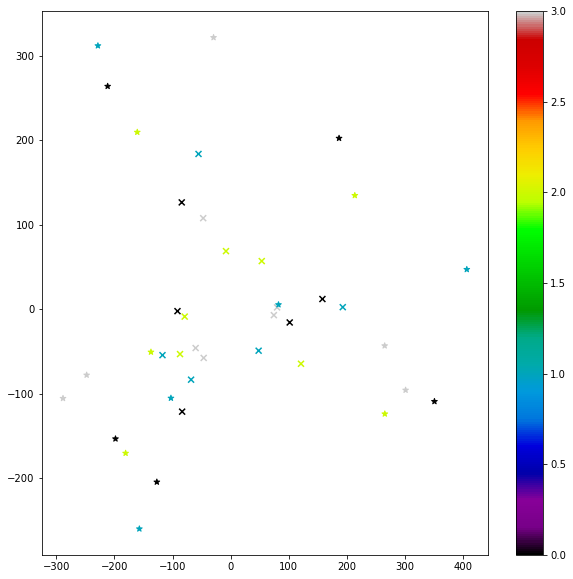

In [23]:
# 2D visualisation of features
plt.figure(figsize=(10, 10))


plt.scatter(vis_activitynet[:,:, 0], vis_activitynet[:,:, 1], c=labels, marker='x', cmap=plt.cm.nipy_spectral, alpha=100)
plt.scatter(vis_baseline[:,:, 0], vis_baseline[:,:, 1], c=labels, marker='*', cmap=plt.cm.nipy_spectral, alpha=100)
#plt.scatter(vis_baseline2[:,:, 0], vis_baseline2[:,:, 1], c=labels, marker='o', cmap=plt.cm.nipy_spectral, alpha=100)
plt.colorbar()

plt.show()

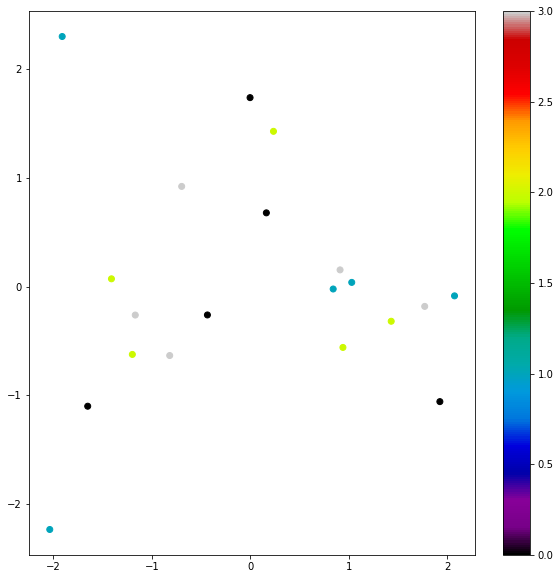

In [24]:
plt.figure(figsize=(10, 10))

plt.scatter(vis_baseline2[:,:, 0], vis_baseline2[:,:, 1], c=labels, marker='o', cmap=plt.cm.nipy_spectral, alpha=100)
plt.colorbar()

plt.show()

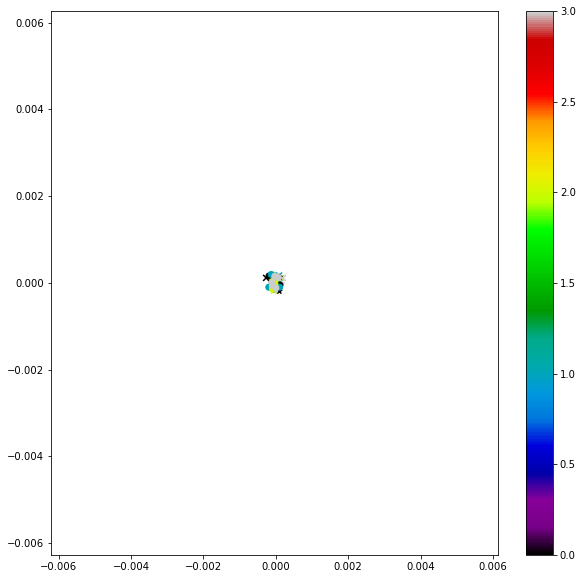

In [25]:
plt.figure(figsize=(10, 10))

plt.scatter(vis_activitynet_tsne[:,:, 0], vis_activitynet_tsne[:,:, 1], c=labels, marker='x', cmap=plt.cm.nipy_spectral, alpha=100)
plt.scatter(vis_baseline_tsne[:,:, 0], vis_baseline_tsne[:,:, 1], c=labels, marker='*', cmap=plt.cm.nipy_spectral, alpha=100)
plt.scatter(vis_baseline2_tsne[:,:, 0], vis_baseline2_tsne[:,:, 1], c=labels, marker='o', cmap=plt.cm.nipy_spectral, alpha=100)

plt.colorbar()

plt.show()